# Modeler Starter Kit
This notebook will walk you through the entire challenge lifecycle, from fetching the training data, to training a model, to submitting your model for evaluation.

## Fetch Training Data
The following code will allow you download the training dataset for this competition using the Spectral cli. 

The training dataset is a tabular parquet file, where each row represents a borrow event at the specified timestamp. 

Each row contains a timestamp and ethereum block number, the wallet address that initiated the borrow transaction, a list of features including borrower and market activity, and a binary target variable indicating if the borrower was liquidated within 30 days of the borrow event.

[See our data dictionary for a full list of features, their types, and descriptions.](https://docs.google.com/spreadsheets/d/1jbHSbIYbNH_6ans-k703HsihedRqFmyKcoSMHitYD_o/edit?usp=sharing)

During testing and consumption you will be given all of these values aside from the target variable. Your model will be evaluated on the ability to predict the target variable for each sample in the test set.



In [1]:
#List available challenges
!spectral-cli list-challenges  

Available challenges:
Credit Scoring: 0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939


In [2]:
# Download Training Data
!spectral-cli fetch-training-data 0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939

100%|███████████████████████████████████████| 112M/112M [00:02<00:00, 40.9MiB/s]
Training dataset successfully downloaded!


This file should be around 112MB, if you have a file only a few kb in size try using a VPN as IPFS is often blocked by some internet service providers.

Examine a subset of the dataset

In [34]:
import duckdb
duckdb.query((f"""
select * from '{'0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939_training_data.parquet'}' limit 10
""")).df()

,borrow_block_number,borrow_timestamp,wallet_address,target,unique_borrow_protocol_count,unique_lending_protocol_count,total_collateral_eth,misc_available_borrows_eth,risk_factor,risk_factor_above_threshold_daily_count,...,total_balance_eth,withdraw_amount_sum_eth,borrow_amount_sum_eth,borrow_amount_avg_eth,borrow_count,repay_amount_sum_eth,repay_amount_avg_eth,repay_count,borrow_repay_diff_eth,withdraw_deposit_diff_If_positive_eth
0,7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,0,1,44.479139,31.575270,0.000001,0.0,...,58.317987,0.0,0.000000,0.000000,0,0.0,0.0,0,0.000000,0.0
1,7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,44.479139,31.418863,0.004953,0.0,...,58.317987,0.0,0.157110,0.157110,1,0.0,0.0,0,0.157110,0.0
2,7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,44.479139,31.035236,0.017103,0.0,...,58.317987,0.0,0.543275,0.271637,2,0.0,0.0,0,0.543275,0.0
3,7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,0,0,1,0.000767,0.000460,0.000001,0.0,...,0.000000,0.0,0.000000,0.000000,0,0.0,0.0,0,0.000000,0.0
4,7712572,1.557217e+09,0xbd9ed130a53cfafcf81502e4d35329a6c4d53410,0,0,1,0.010000,0.007500,0.000001,0.0,...,0.000000,0.0,0.000000,0.000000,0,0.0,0.0,0,0.000000,0.0
5,7715069,1.557250e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,44.488424,30.059852,0.048606,0.0,...,58.317987,0.0,1.543275,0.514425,3,0.0,0.0,0,1.543275,0.0
6,7715078,1.557251e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,44.430545,29.912079,0.052241,0.0,...,58.317987,0.0,1.543275,0.514425,4,0.0,0.0,0,1.543275,0.0
7,7715985,1.557263e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,51.316928,28.781848,0.088052,0.0,...,58.317987,0.0,2.749083,0.687271,5,0.0,0.0,0,2.749083,0.0
8,7716888,1.557276e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,58.791139,38.667542,0.081422,0.0,...,3.127926,0.0,3.320086,0.664017,6,0.0,0.0,0,3.320086,0.0
9,7717003,1.557277e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,60.268602,33.574491,0.221625,0.0,...,3.127926,0.0,9.247470,1.541245,7,0.0,0.0,0,9.247470,0.0


You may choose to use any subset of the data above to train your model. We guarantee availability of this data during the challenge lifespan.
You may also supplement this set with external data, however you will be responsible for hosting and serving this data during testing and consumption.

## Exploratory Data Analysis

You may use any tools you wish to explore the data and generate features. As an example we examine the max_risk_factor feature, look for potential outliers, consider dropping those samples, and examine correlated features

In [4]:
import pandas as pd
training_dataframe = duckdb.query((f"""
select * from '{'0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939_training_data.parquet'}'
""")).df()
training_dataframe['max_risk_factor'].describe()

count    4.316180e+05
mean     2.946256e+08
std      3.271465e+10
min      0.000000e+00
25%      4.379520e-01
50%      7.663844e-01
75%      9.154721e-01
max      3.633082e+12
Name: max_risk_factor, dtype: float64

The max value listed above is far greater than the majority of samples, and may be an outlier. A risk factor over one is uncommon, so a value this large could be due to a highly irregular onchain action, an error in data fetching, or an error dataset construction. 

We should examine samples with high values of this feature.

In [5]:
duckdb.query((f"""
select count(distinct(wallet_address)) as unusually_high_risk_factor_address from '{'0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939_training_data.parquet'}'
where max_risk_factor > 100
""")).df()

,unusually_high_risk_factor_address
0,61


There are 61 addresses with this unusually high value, let's remove all samples with a risk factor over 100 from training. 

In [6]:
training_dataframe = duckdb.query((f"""
select * from '{'0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939_training_data.parquet'}'
where max_risk_factor < 100
""")).df()
training_dataframe['max_risk_factor'].describe()

count    429835.000000
mean          0.806303
std           2.302598
min           0.000000
25%           0.434355
50%           0.764848
75%           0.913552
max          86.364163
Name: max_risk_factor, dtype: float64

A risk factor of 86 is still highly unusual, but we will leave it in for now as this is only an example.

It's always helpful to visualize data when getting acquainted, so let's examine a few features together. We'll look at the correlation between the withdraw_deposit_diff_If_positive_eth, withdraw_amount_sum_eth, and deposit_amount_sum_eth features.


These defi features represent the total amount of eth withdrawn, deposited, and the difference between the two.

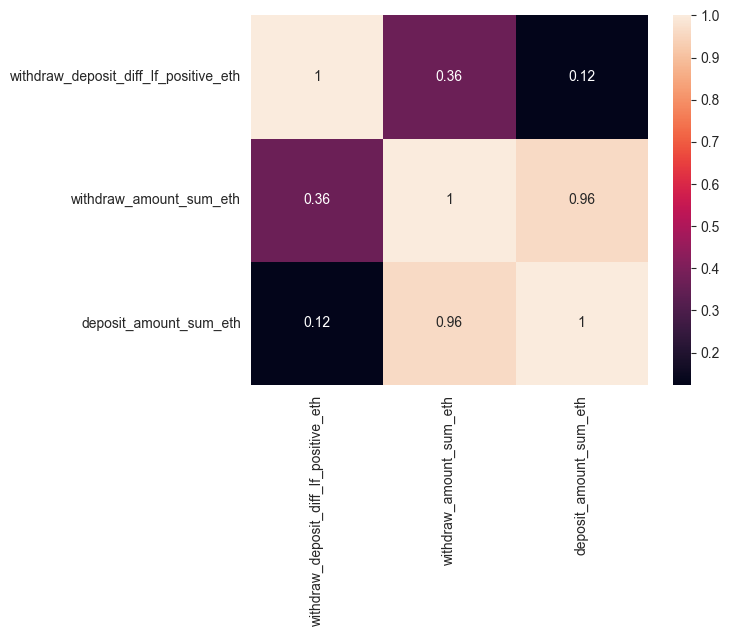

In [7]:
import matplotlib.pyplot as mp 
import seaborn as sb 
dataplot = sb.heatmap(training_dataframe[['withdraw_deposit_diff_If_positive_eth',
                                          'withdraw_amount_sum_eth',
                                          'deposit_amount_sum_eth' ]].corr(), annot=True) 
mp.show() 

These features represent actions on opposite ends of the lending lifecycle, so we could reasonably expect there to be some correlation for many samples.

withdraw_amount_sum_eth and deposit_amount_sum_eth are highly correlated, so we'll move to drop withdraw_amount_sum_eth from our training set. In practice it would be beneficial to examine the correlation between other features and understand why some of these may be correlated or not.  

In [8]:
import duckdb
training_dataframe = duckdb.query((f"""
select * from '{'0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939_training_data.parquet'}'
where max_risk_factor < 100
""")).df().drop(columns=['withdraw_amount_sum_eth'], inplace=False)

For this example we'll conclude our analysis, and move to modelling. During the challenge you should spend time exploring the data and generating features. There is no shortage of exciting onchain activity that could be used to generate features, and we encourage you to be creative. 


Features derived from activity on other lending protocols, other chains, non-fungibile token value, and decentralized exchange positions have all proven to be relevant in our previous work. Want to discuss with other modelers and our team? Join our [Discord](https://discord.com/invite/Vqwhxva7Y2)

## Modeling


### Train a neural net using the dataset above

This model is strictly for example purposes, and is not intended to be a "good" model. 
You should not make assumptions based on this model that this is how the problem should be approached


In particular, you should not assume:
- anything about the relevancy of features and samples dropped above
- that loss and accuracy are appropriate metrics for this problem
- that ReLU is the ideal activation function (or any other architecture specifics defined herein)

In [9]:
import pandas as pd
import numpy as np
import duckdb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import json
from tqdm.auto import tqdm
from timeit import default_timer as timer 
import random
import os

# Spectral Helpers (see helpers folder for more details on any of these
from helpers.modeling import TestData, TrainData, StratifiedBatchSampler, print_train_time, auc_fn, auroc_fn, auc_pr_fn, brier_fn, ks_fn, recall_fn, prob_diff_fn, f1_score_fn, train_step, test_step, eval_model, plot_loss_curves,ValidationLossEarlyStopping, predict_on_test_sample

# for reproducible results
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.use_deterministic_algorithms(True, warn_only=True)
torch.backends.cudnn.determenistic=True

random.seed(random_seed)
def seed_worker(worker_id):
    worker_seed = random_seed
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(random_seed)

#specifically required for reproducibility with CuBLABS and CUDA
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8" 
os.environ["PYTHONHASHSEED"] = str(random_seed)

We'll use the same training dataset we defined above, and split it into training and testing sets.

***TODO: Fix when Data api is up***

In [10]:
# We're going to hold out 10K samples for "realtime" testing while data api is down
example_testing_samples = training_dataframe[-10_000:]
training_dataframe = training_dataframe[:-10_000]


In [11]:
training_cols = list(training_dataframe.columns.drop(
    ['borrow_timestamp', 'wallet_address', 'borrow_block_number', 'target']))



X_train, X_test, y_train, y_test = train_test_split(training_dataframe[training_cols].to_numpy(),
                                                    training_dataframe['target'].to_numpy(), test_size=0.2, random_state=random_seed)


sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [12]:
train_data = TrainData(torch.from_numpy(X_train_scaled).type(torch.float), torch.from_numpy(y_train).type(torch.float))
test_data = TestData(torch.from_numpy(X_test_scaled).type(torch.float), torch.from_numpy(y_test).type(torch.float))

In [13]:

NUM_WORKERS = 0 # use all available CPU cores with os.cpu_count(), if possible
BATCH_SIZE = int(X_train.shape[0]/100) # ~1% of the training data
# initialize DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_sampler=StratifiedBatchSampler(torch.tensor(y_train), batch_size=BATCH_SIZE), 
                              worker_init_fn=seed_worker, 
                              generator=g,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             worker_init_fn=seed_worker,
                             generator=g,
                             num_workers=NUM_WORKERS)

print(f'Dataloaders: {train_dataloader, test_dataloader}') 
print(f'Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}')
print(f'Using number of workers: {NUM_WORKERS}')

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x2ff80bc10>, <torch.utils.data.dataloader.DataLoader object at 0x2fe3bfc10>)
Length of train dataloader: 101 batches of 3358
Length of test dataloader: 26 batches of 3358
Using number of workers: 0


In [14]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([3326, 73]), torch.Size([3326]))

In [15]:
# Check out what's inside the testing dataloader
test_features_batch, test_labels_batch = next(iter(test_dataloader))
test_features_batch.shape, test_labels_batch.shape

(torch.Size([3358, 73]), torch.Size([3358]))

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### One hidden layer with ReLU activation

In [17]:
# define NN architecture
class PredictLiquidationsV1(nn.Module):
    """
    The final layer should be a sigmoid, to get the probability of liquidation. 
    """
    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p = 0.4),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            nn.Sigmoid()
        )        
        
    def forward(self, x):
        return self.linear_layer_stack(x)
    
# instantiate the model
model_1 = PredictLiquidationsV1(input_features=X_train.shape[1],
                                output_features=1,
                                hidden_units=82).to(device)
model_1

PredictLiquidationsV1(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=73, out_features=82, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=82, out_features=82, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=82, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [18]:
early_stopper = ValidationLossEarlyStopping(patience=1, min_delta=0.0)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(params=model_1.parameters(),
                       lr=0.001,
                       weight_decay=0.01)

In [19]:
compiled_model_1 = torch.compile(model_1)

In [20]:
# Measure time
train_time_start = timer()

epochs = 30

# Create empty loss lists to track values
model_1_train_loss_values = []
model_1_test_loss_values = []
model_1_epoch_count = []

for epoch in tqdm(range(epochs)):
    if epoch % 5 == 0:
        print(f"Epoch: {epoch}\n---------")
    train_metrics = train_step(data_loader=train_dataloader, 
                               model=compiled_model_1, 
                               epochs=epoch,
                               loss_fn=loss_fn,
                               optimizer=optimizer,
                               auc_fn=auc_fn,
                               recall_fn=recall_fn,
                               f1_score_fn=f1_score_fn,
                               auroc_fn=auroc_fn,
                               brier_fn=brier_fn,
                               auc_pr_fn=auc_pr_fn,
                               ks_fn=ks_fn,
                               prob_diff_fn=prob_diff_fn
    )
    test_metrics = test_step(data_loader=test_dataloader,
                             model=compiled_model_1,
                             epochs=epoch,
                             loss_fn=loss_fn,
                             auc_fn=auc_fn,
                             recall_fn=recall_fn,
                             f1_score_fn=f1_score_fn,
                             auroc_fn=auroc_fn,
                             brier_fn=brier_fn,
                             auc_pr_fn=auc_pr_fn,
                             ks_fn=ks_fn,
                             prob_diff_fn=prob_diff_fn
    )
    model_1_epoch_count.append(epoch)
    model_1_train_loss_values.append(train_metrics['loss'])
    model_1_test_loss_values.append(test_metrics['loss'])
    
    if early_stopper.early_stop_check(test_metrics['loss']):
        print(f"Stopped early at epoch: {epoch}\n---------")
        print(f"Training metrics:\nLoss: {train_metrics['loss']:.5f} | Recall: {train_metrics['recall']:.2f}% | F1-Score: {train_metrics['f1']:.2f}% | AUROC: {train_metrics['auroc']:.2f}% | Brier Score: {train_metrics['brier']:.2f}% | AUC PR: {train_metrics['aucpr']:.2f}% | KS-Statistic: {train_metrics['ks']:.2f}% | Pred Prob Diff: {train_metrics['prob_diff']:.2f}%")
        print(f"Testing metrics:\nLoss: {test_metrics['loss']:.5f} | Recall: {test_metrics['recall']:.2f}% | F1-Score: {test_metrics['f1']:.2f}% | AUROC: {test_metrics['auroc']:.2f}% | Brier Score: {test_metrics['brier']:.2f}% | AUC PR: {test_metrics['aucpr']:.2f}% | KS-Statistic: {test_metrics['ks']:.2f}% | Pred Prob Diff: {test_metrics['prob_diff']:.2f}%")
        break

train_time_end = timer()
total_train_time_model_1 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------
Training metrics:
Loss: 0.56654 | Recall: 40.03% | F1-Score: 49.42% | AUROC: 74.66% | Brier Score: 19.15% | AUC PR: 70.12% | KS-Statistic: 40.43% | Pred Prob Diff: 18.84%
Testing metrics:
Loss: 0.49981 | Recall: 58.16% | F1-Score: 67.00% | AUROC: 80.54% | Brier Score: 16.32% | AUC PR: 78.26% | KS-Statistic: 49.89% | Pred Prob Diff: 35.15%
Epoch: 5
---------
Training metrics:
Loss: 0.46830 | Recall: 58.75% | F1-Score: 68.02% | AUROC: 83.41% | Brier Score: 15.18% | AUC PR: 80.69% | KS-Statistic: 52.13% | Pred Prob Diff: 40.55%
Testing metrics:
Loss: 0.46395 | Recall: 59.99% | F1-Score: 68.93% | AUROC: 83.88% | Brier Score: 15.02% | AUC PR: 81.24% | KS-Statistic: 53.56% | Pred Prob Diff: 42.00%
Epoch: 10
---------
Training metrics:
Loss: 0.46593 | Recall: 58.94% | F1-Score: 68.21% | AUROC: 83.64% | Brier Score: 15.09% | AUC PR: 80.90% | KS-Statistic: 52.48% | Pred Prob Diff: 40.93%
Testing metrics:
Loss: 0.46178 | Recall: 60.14% | F1-Score: 69.06% | AUROC: 84.10% | Brie

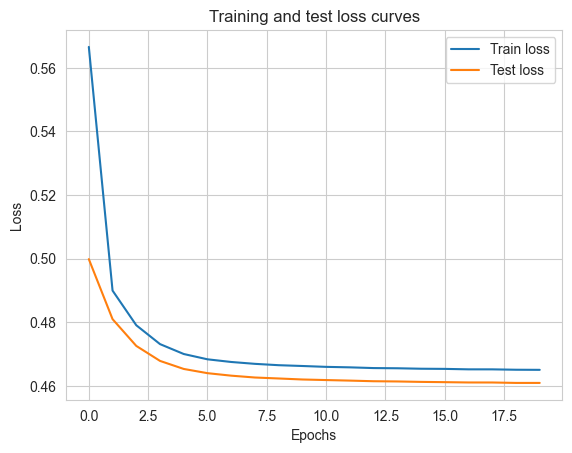

In [21]:
plot_loss_curves(model_1_epoch_count, model_1_train_loss_values, model_1_test_loss_values)

In [22]:
# Calculate model 1 results
model_1_results = eval_model(model=compiled_model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             auc_fn=auc_fn,
                             recall_fn=recall_fn,
                             f1_score_fn=f1_score_fn,
                             auroc_fn=auroc_fn,
                             brier_fn=brier_fn,
                             auc_pr_fn=auc_pr_fn,
                             ks_fn=ks_fn,
                             prob_diff_fn=prob_diff_fn,
                             device=device)
model_1_results.update({'model_name': model_1.__class__.__name__})

model_1_results

{'model_name': 'PredictLiquidationsV1',
 'model_loss': 0.460879921913147,
 'model_rec': 60.292740895197944,
 'model_f1': 69.15935927170973,
 'model_auroc': 84.22744780320387,
 'model_brier': 14.905121133535424,
 'model_aucpr': 81.52356881361742,
 'model_ks': 53.85187535400367,
 'model_prob_diff': 42.5647748204378}

# Export to ONNX

In [23]:
if not os.path.exists('submissions'):
    os.makedirs('submissions')

In [24]:
model_1.eval()
torch.onnx.export(model_1,
                  torch.randn((1,X_train.shape[1]), requires_grad = True).to(device),
                  'submissions/model_1.onnx',
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes = {'input' : {0 : 'batch_size'}, 
                                  'output' : {0 : 'batch_size'}})

In [25]:
# export an observation from the test dataset that will be used to calibrate the ezkl settings file. This list of feature values can be from the test data (as shown here) or a completeley different sample that will be representative of the data to be seend in prod
x = next(iter(test_features_batch)).numpy().tolist()
data = dict(input_data = [x])
json.dump(data, open('submissions/model_1_cal_data.json', 'w'))

# Generate Predictions

In [26]:
# Create a new dataframe for submission
submission_dataframe = pd.DataFrame([])

In [27]:
submission_dataframe['wallet_address'], submission_dataframe['probability_of_liquidation'], submission_dataframe['input_for_prediction'] = zip(*example_testing_samples.apply(lambda row: predict_on_test_sample(row, training_cols, model_1), axis=1))

As a modeler you will choose to set the target variable to 1 if the probability of liquidation is greater than some threshold.

In this example we'll take the threshold to be .6, but you may find a different value is more appropriate

In [28]:
submission_dataframe['target'] = submission_dataframe['probability_of_liquidation'].apply(lambda x: 1 if x > .6 else 0)

To format our dataframe for submission, we'll store the wallet_address, probability, target, and the input features used to generate the prediction.

Input features should follow the naming convention below

In [29]:
df = pd.DataFrame([pd.Series(x) for x in submission_dataframe['input_for_prediction']])
df.columns = ['feature_{}'.format(x+1) for x in df.columns]


# Merge and save results
submission_dataframe = submission_dataframe.merge(df, left_index=True, right_index=True).drop(columns=['input_for_prediction'])
submission_dataframe.to_parquet('submissions/submission_dataframe.parquet')

In [30]:
submission_dataframe.head()

,wallet_address,probability_of_liquidation,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73
0,0x49654d0584e777e3f8de4f932e2d6432e39c1cf5,0.0,0,1.0,1.0,188.763245,102.935135,0.339014,0.0,0.816839,...,0.001785,0.303029,5.864956,0.733120,8.0,0.0,0.0,0.0,5.864956,0.0
1,0x49654d0584e777e3f8de4f932e2d6432e39c1cf5,0.0,0,1.0,1.0,188.763245,88.076187,0.434429,0.0,0.816839,...,0.001785,0.303029,7.777018,0.864113,9.0,0.0,0.0,0.0,7.777018,0.0
2,0x49654d0584e777e3f8de4f932e2d6432e39c1cf5,0.0,0,1.0,1.0,188.763245,78.616051,0.495176,0.0,0.816839,...,0.001785,0.303029,7.777018,0.777702,10.0,0.0,0.0,0.0,7.777018,0.0
3,0x49654d0584e777e3f8de4f932e2d6432e39c1cf5,0.0,0,1.0,1.0,188.763245,67.392860,0.567245,0.0,0.816839,...,0.001785,0.303029,9.213414,0.837583,11.0,0.0,0.0,0.0,9.213414,0.0
4,0x49654d0584e777e3f8de4f932e2d6432e39c1cf5,0.0,0,1.0,1.0,188.763245,50.214287,0.677555,0.0,0.816839,...,0.001785,0.303029,11.415947,0.951329,12.0,0.0,0.0,0.0,11.415947,0.0


# Commit to a Model


**Seemingly broken on 0.0.6 and 0.0.7, maybe local issue?**

In [ ]:
!spectral-cli commit submissions/model_1.onnx submissions/model_1_cal_data.json 0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939

# Submission 

Ensure your cil wallet is funded


**Also seemingly broken?**

In [32]:
# !spectral-cli commit model_1.onnx model_1_cal_data.json 0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939

In [33]:
# ! spectral-cli submit-inferences 0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939 submissions/submission_dataframe.parquet